# [ Going Deeper(CV) ] 4. 이미지 어디까지 우려볼까?

✅정의

---
### - 📖목차
* ✔️4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기
* ✔️더 좋은 네트워크 만들어보기
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기
---
### 1. Augmentation을 적용한 데이터셋 만들기


https://github.com/HRPzz/AIFFEL/blob/1e57e4338a7d3c1e0c283ba59d0a38ab12b1c044/GOING_DEEPER_CV/Node_04/%5BCV-04%5D%20CutMix_vs_Mixup.ipynb

In [1]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSL9W1I/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSL9W1I/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [6]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

In [7]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

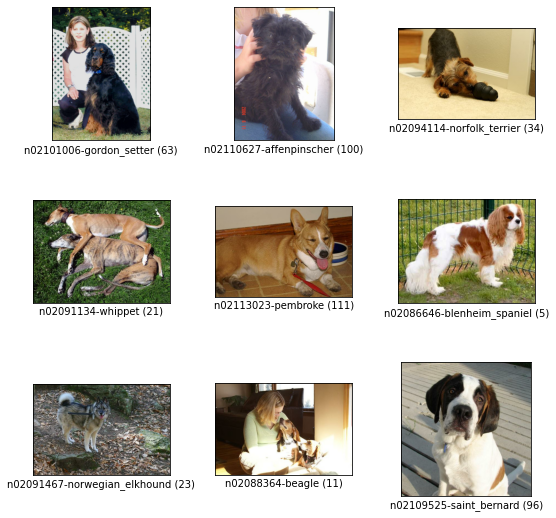

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

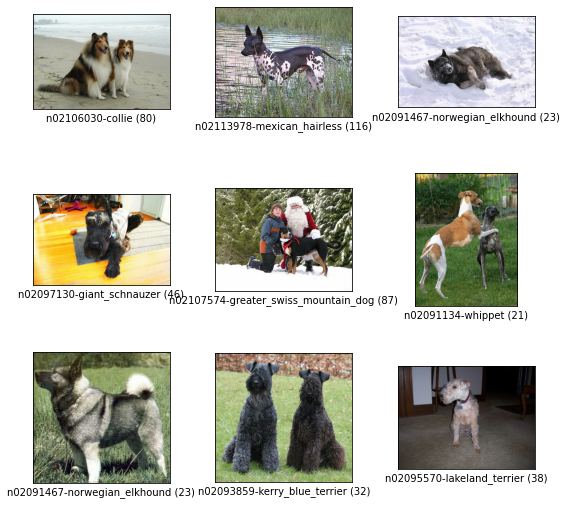

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

In [10]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [11]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [13]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [14]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [15]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [18]:
def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

In [19]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
# BATCH_SIZE = 16

strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [21]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)

In [22]:
# 데이터셋에서 이미지 가져와서 시각화
def draw_ds_train(ds_train, batch_size=16, row=6, col=4):
    row = min(row, batch_size//col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize=(8,int(8*row/col)))  # 8x8 크기
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

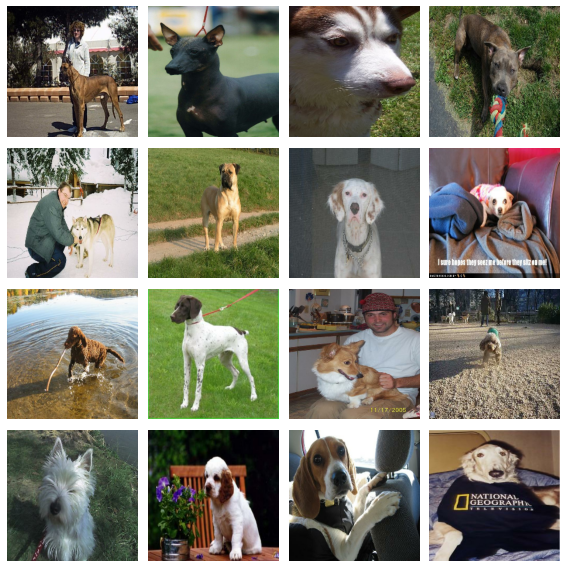

In [23]:
draw_ds_train(ds_train_no_aug, BATCH_SIZE)

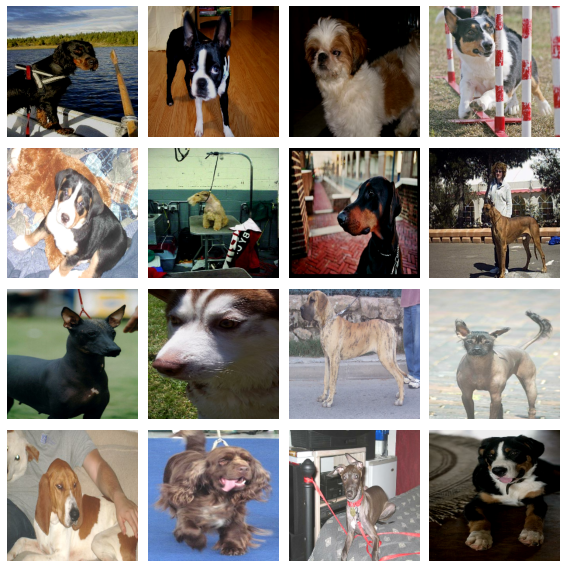

In [62]:
draw_ds_train(ds_train_aug, BATCH_SIZE)

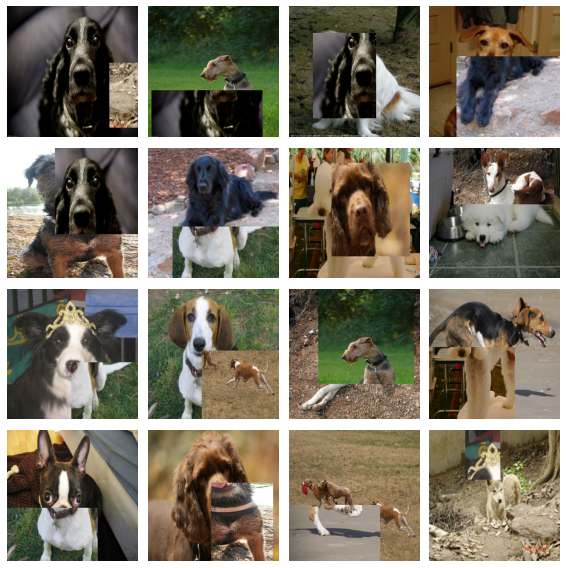

In [63]:
draw_ds_train(ds_train_aug_cutmix, BATCH_SIZE)

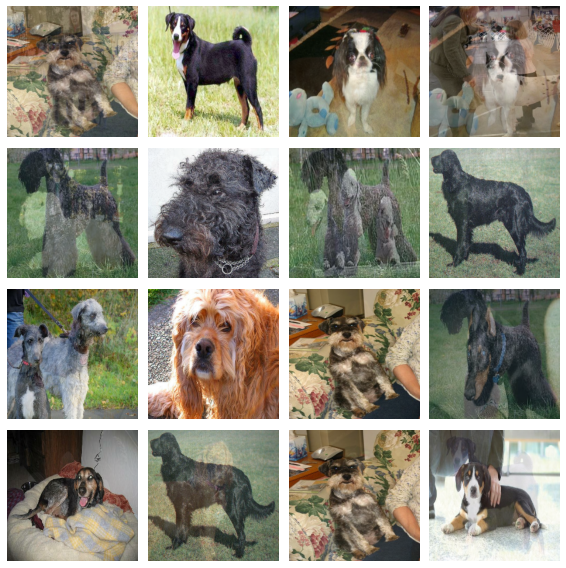

In [64]:
draw_ds_train(ds_train_aug_mixup, BATCH_SIZE)

<br>

### 2. 모델 만들기

In [24]:
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

In [25]:
resnet50_no_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_no_aug 으로 학습시킬 ResNet
resnet50_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug 으로 학습시킬 ResNet
resnet50_aug_cutmix = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_cutmix 으로 학습시킬 ResNet
resnet50_aug_mixup = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_mixup 으로 학습시킬 ResNet

94781440/94765736 [==============================] - 0s 0us/step


In [26]:
EPOCH = 10

LEARNING_RATE = 0.01

Learning rate schedule: 0.001 to 0.05 to 0.000819


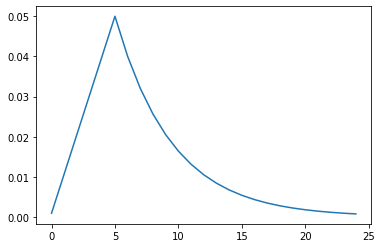

In [27]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.001  # 0.00001
LR_MAX = 0.05 * strategy.num_replicas_in_sync  # 0.00005
LR_MIN = 0.0001  # 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCH<25 else EPOCH)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [28]:
def compile_and_fit(resnet50,
                    ds_train,
                    ds_test,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=16,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        callbacks=[lr_callback],
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

<br>

### 3. 모델 훈련하기

In [70]:
history_resnet50_no_aug = compile_and_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
750/750 [==============================] - 1603s 2s/step - loss: 4.4376 - accuracy: 0.0817 - val_loss: 4.6470 - val_accuracy: 0.0585 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/10
750/750 [==============================] - 1554s 2s/step - loss: 1.7692 - accuracy: 0.5276 - val_loss: 1.6250 - val_accuracy: 0.5549 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/10
750/750 [==============================] - 1558s 2s/step - loss: 1.0756 - accuracy: 0.6821 - val_loss: 2.8093 - val_accuracy: 0.3203 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/10
750/750 [==============================] - 1577s 2s/step - loss: 0.8774 - accuracy: 0.7370 - val_loss: 2.1902 - val_accuracy: 0.4573 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/10
750/750 [============================

In [29]:
history_resnet50_aug = compile_and_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
750/750 [==============================] - 1482s 2s/step - loss: 4.4813 - accuracy: 0.0728 - val_loss: 4.4585 - val_accuracy: 0.0710 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/10
750/750 [==============================] - 2032s 3s/step - loss: 1.8516 - accuracy: 0.5052 - val_loss: 2.0134 - val_accuracy: 0.4576 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/10
750/750 [==============================] - 2006s 3s/step - loss: 1.2840 - accuracy: 0.6266 - val_loss: 2.3990 - val_accuracy: 0.4080 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/10
750/750 [==============================] - 1841s 2s/step - loss: 1.1610 - accuracy: 0.6584 - val_loss: 2.5057 - val_accuracy: 0.3934 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/10
750/750 [============================

In [30]:
history_resnet50_aug_cutmix = compile_and_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
750/750 [==============================] - 1727s 2s/step - loss: 4.8824 - accuracy: 0.0229 - val_loss: 5.1090 - val_accuracy: 0.0269 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/10
750/750 [==============================] - 1965s 3s/step - loss: 3.5882 - accuracy: 0.2637 - val_loss: 1.6512 - val_accuracy: 0.5494 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/10
750/750 [==============================] - 1870s 2s/step - loss: 3.0595 - accuracy: 0.3864 - val_loss: 1.9904 - val_accuracy: 0.4882 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/10
750/750 [==============================] - 1952s 3s/step - loss: 2.8573 - accuracy: 0.4392 - val_loss: 2.1082 - val_accuracy: 0.4588 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/10
750/750 [============================

<br>

* 뭔가... 제대로 학습이 안되고 있다는 생각이 들어서 다시 에폭수를 바꿈(그리고 너무 오래 걸림....)

In [ ]:
history_resnet50_no_aug = compile_and_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 192s 244ms/step - loss: 4.4361 - accuracy: 0.0786 - val_loss: 4.5976 - val_accuracy: 0.0566 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 182s 243ms/step - loss: 1.7903 - accuracy: 0.5225 - val_loss: 1.4641 - val_accuracy: 0.5833 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 183s 244ms/step - loss: 1.0472 - accuracy: 0.6917 - val_loss: 1.5837 - val_accuracy: 0.5704 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 183s 244ms/step - loss: 0.9015 - accuracy: 0.7270 - val_loss: 2.2150 - val_accuracy: 0.4630 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

In [ ]:
history_resnet50_aug = compile_and_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 189s 245ms/step - loss: 4.4543 - accuracy: 0.0737 - val_loss: 4.4897 - val_accuracy: 0.0626 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 183s 244ms/step - loss: 1.8535 - accuracy: 0.5067 - val_loss: 1.7061 - val_accuracy: 0.5335 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 182s 243ms/step - loss: 1.2705 - accuracy: 0.6309 - val_loss: 1.8204 - val_accuracy: 0.5226 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 183s 244ms/step - loss: 1.1924 - accuracy: 0.6522 - val_loss: 3.0157 - val_accuracy: 0.3235 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

In [ ]:
history_resnet50_aug_cutmix = compile_and_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 195s 253ms/step - loss: 4.8659 - accuracy: 0.0246 - val_loss: 4.9811 - val_accuracy: 0.0321 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 191s 254ms/step - loss: 3.6002 - accuracy: 0.2616 - val_loss: 1.7170 - val_accuracy: 0.5336 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 192s 256ms/step - loss: 3.0473 - accuracy: 0.3957 - val_loss: 1.8984 - val_accuracy: 0.4927 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 192s 256ms/step - loss: 2.8840 - accuracy: 0.4412 - val_loss: 2.3294 - val_accuracy: 0.4165 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

In [ ]:
history_resnet50_aug_mixup = compile_and_fit(
    resnet50_aug_mixup,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
750/750 [==============================] - 197s 256ms/step - loss: 4.8458 - accuracy: 0.0237 - val_loss: 5.1664 - val_accuracy: 0.0177 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/30
750/750 [==============================] - 191s 255ms/step - loss: 3.4882 - accuracy: 0.2928 - val_loss: 1.8042 - val_accuracy: 0.5026 - lr: 0.0108

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/30
750/750 [==============================] - 192s 256ms/step - loss: 3.0198 - accuracy: 0.4206 - val_loss: 2.0438 - val_accuracy: 0.4613 - lr: 0.0206

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/30
750/750 [==============================] - 190s 254ms/step - loss: 2.8662 - accuracy: 0.4709 - val_loss: 2.4604 - val_accuracy: 0.3759 - lr: 0.0304

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/30
750/750 [

### 4. 훈련 과정 시각화하기

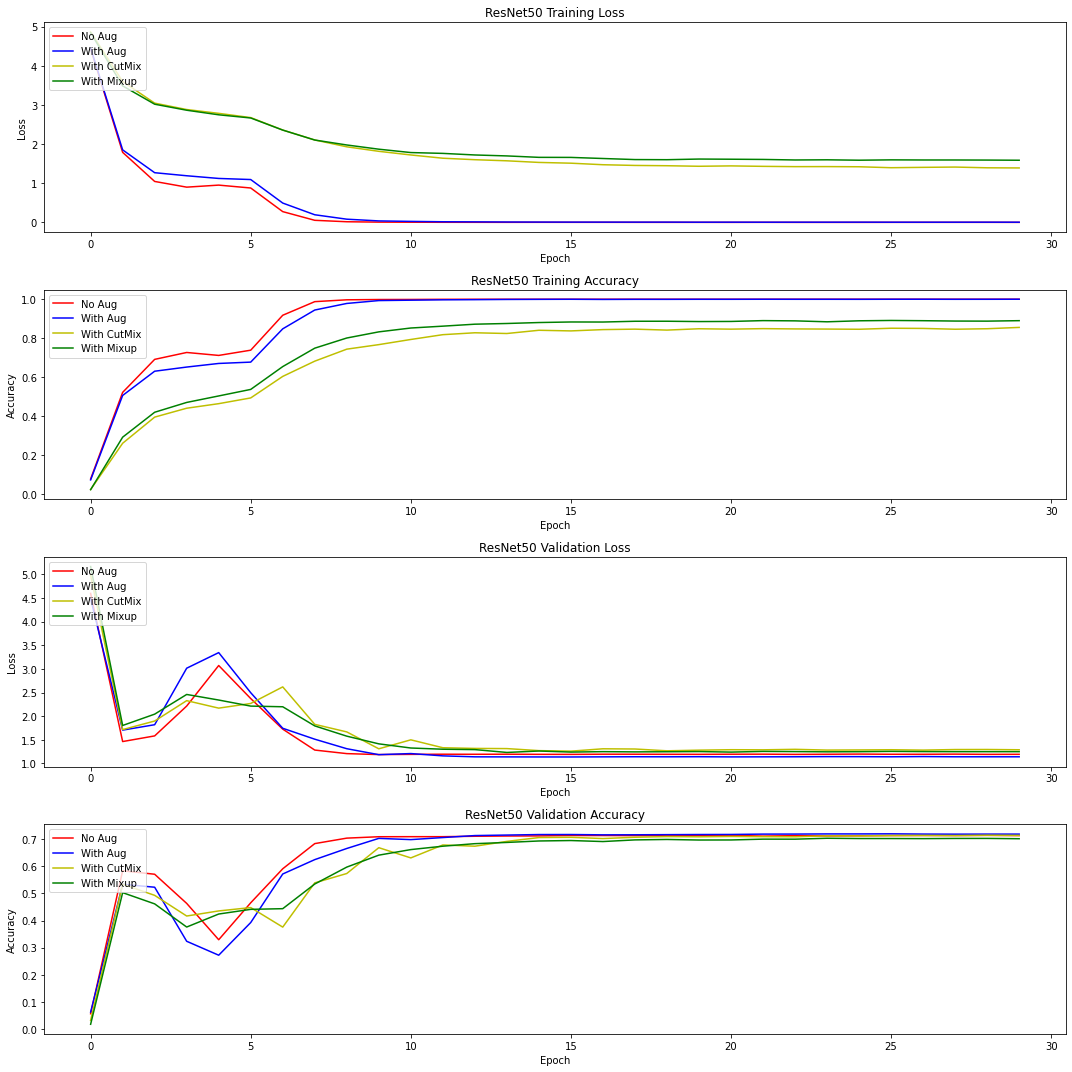

In [ ]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.savefig('result/Results_With_all_Aug.png')  # 저장
plt.show()

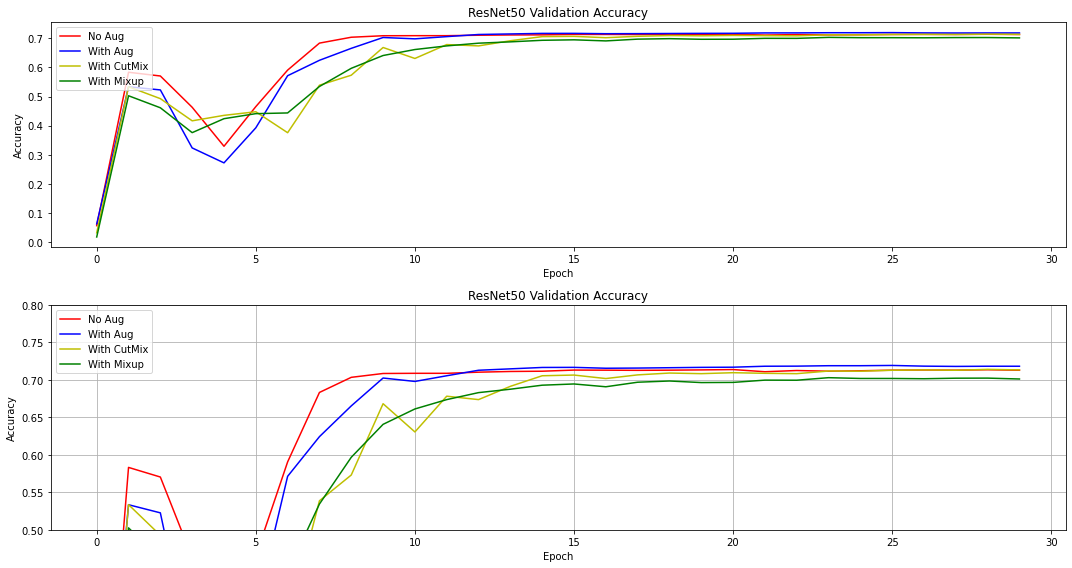

In [ ]:
plt.subplots(figsize=(15,8))

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화
plt.subplot(211)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화 2
plt.subplot(212)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.tight_layout()
plt.savefig('result/Validation_Accuracy_With_Aug.png')  # 저장
plt.show()

### 5. Augmentation에 의한 모델 성능 비교

1. 에폭 10으로 먼저 돌려보고 나서 뭔가 결과가 엇비슷하다... 싶어서 30으로 돌렸는데 둘다 비슷한 결과를 보여줘서 내가 세팅을 잘못했나? 를 고민하게 만들었다.
2. Cutmix와 Mixup 둘다 No Augmentation의 효율보다 낮았다는 것을 확인할 수 있었다.
3. 그 와중에 Augmentation을 같이 쓴 경우가 엇비슷하게 올라온것 까지는 확인했는데, 묘하게 0.7이 피크였는지 그 위로는 계속 멈춰있는 것을 확인했다.

= 생각보다 Augmentation의 효과를 기대하는건 쉽지 않았다.....

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

![20220711153618](https://user-images.githubusercontent.com/100528803/178983718-10545cbb-9a58-4349-b99f-fd205361adf4.png)

에폭시간 무엇....
(심지어 이것도 시간 끝난거 아님)

진짜 여러가지 간단하게 뭘 돌리고 싶더라도 시간이 절대적으로 오래 걸리는 관계로 그냥 기본 베이스적인 거, 혹은 성공이 보장되어 있는 셋 정도만을 쓸 수 있다는게 사실 좀 답답했다. 근데 이걸 제대로 돌릴라면... 아이펠톤 기간 정도에나 가능하다는 계산이 나오기 떄문에 그냥 넘기기로 했다.

1. 왜 코랩은 일정 시간마다 내가 기계인지를 물어보는 것이며
2. 내가 조금이라도 졸고 있으면 가차없이 연결을 끊는 것이며(90분...찐으로 계산하는게 맞나 30분 같다 진짜로)
3. 아예 연결이 끊기면 피클로 저장할껄 매번 후회하면서도 왜 아직까지 쓰질 않는가......
진짜 담번부터는 피클을 어떻게서든 써서 하루씩 여유롭게 쓰고 싶다 이번에는 너무.....집에서도 돌리고 아이펠에서도 돌리고 거의 코랩을 못쓰다시피하게 만든 프로젝트였다.
4. 그래서 결국 자바 스크립트로 안끊기는 법을 찾아버렸으므로 다음 플젝때부터는 가차없이 쓰기로함(왜 끝나서야 찾았지)

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

그래서 Augmentation은 어떻게 쓰여야 제대로 쓰이는 걸까요...가 새삼스레 궁금해졌다. 최근 관련 논문이랑 추세를 살펴보니 아예 어그멘테이션을 효율적으로 쓸 수 있게 AI가 스스로 그리드 서치하는 것처럼 방식을 찾아줄 정도로 발전했다고 하는데 이게 시간이 어마어마하게 걸린다는 말에 살짝 슬퍼졌다.
장비빨로 싸우게 될 우리의 미래...괜찮을까요.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?                                 | CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.<br>                                                        |
| **2** | 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? | Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함                               |
| **3** | 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?                                    | 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다. |

사실 loss값 자체에서는 이미 성능향상이 충분히 이루어진 상태이긴 했지만 개인적으로는 validation의 여부가 제일 신경쓰였다. 그 외에 시각화...는 나중에 텐서플로우 대쉬보드 같은 걸로 구현하고 싶은데 이번에는 못한게 좀 아쉽다(그리고 구현하려다가 자꾸 에러가 나는데 이유를...모르겠네요 좀 더 시간이 있어야 구현 가능할 듯)


<br>

#### ▶️ 자기 다짐

CV는 정말 시간과의 싸움 같다. 그리고 이번에 제대로 느낀 거지만 반드시 성능 좋은 pre-trained 모델을 파인 튜닝해서 쓰는게 베스트임을 체감했다(내가 처음부터 학습하지 말자 그런 생각 자체를 갖지 말자....가 이번의 가장 큰 자기다짐이다)

<br>

## ✔️Reference(참고자료)
---
* https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook
* https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
* https://hwiyong.tistory.com/215
* https://hongl.tistory.com/223
* https://everyday-image-processing.tistory.com/145